In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import path

In [2]:
def convert_to_mb(bytes):
    return bytes / (1024.0 * 1024.0)

In [3]:
def callculate_data(df):
    df['corrected_alloc'] = (df['allocated'] - df['correction']).apply(convert_to_mb)
    df['correction'] = df['correction'].apply(convert_to_mb)
    df['allocated'] = df['allocated'].apply(convert_to_mb)
    df['resident'] = df['resident'].apply(convert_to_mb)
    return df

In [4]:
data_path = "../results"
dfs = []
for f in [f for f in os.listdir(data_path) if path.isfile(path.join(data_path, f))]:
    name = path.basename(f)
    if name.split('.')[-1] == "tsv":
        parts = name.split('.')[0].split('_')
        sim_type = '_'.join(parts[:-2])
        x = int(parts[-2])
        y = int(parts[-1])
        df = pd.read_csv(data_path+ '/' + name, sep="\t")
        df['x'] = x
        df['y'] = y
        df['sim_type'] = sim_type
        
        dfs.append(callculate_data(df))
        
df = pd.concat(dfs)
df[df['x'] == 128]

,id,allocated,resident,correction,x,y,sim_type,corrected_alloc
0,0,0.159401,3.140625,0.000000,128,4096,rc+,0.159401
1,1,1.198891,4.746094,0.000122,128,4096,rc+,1.198769
2,2,1.467323,5.058594,0.000122,128,4096,rc+,1.467201
3,3,1.592445,5.300781,0.000122,128,4096,rc+,1.592323
4,4,1.711464,5.410156,0.000122,128,4096,rc+,1.711342
...,...,...,...,...,...,...,...,...
125,125,19.738884,24.289062,0.003906,128,4096,rc,19.734978
126,126,19.921989,24.417969,0.003906,128,4096,rc,19.918083
127,127,20.112419,24.574219,0.003906,128,4096,rc,20.108513
128,128,20.295525,24.726562,0.003906,128,4096,rc,20.291618


In [5]:
def plot_memory(df, label):
    df = df.sort_values(by=['id'])
    plt.plot(df['id'], df['corrected_alloc'], '.', label=label)


In [6]:
def make_plot_mem(df, x, y , log = False):
    df_x = df[df['x'] == x]
    df_xy = df_x[df_x['y'] == y]
    df_naive =   df_xy[df_xy['sim_type'] == 'naive']
    df_rc =      df_xy[df_xy['sim_type'] == 'rc']
    df_linear =  df_xy[df_xy['sim_type'] == 'linear']

    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.title(f"Allocated memory comparison between simulation types.\n Grid Size {x}x{y}")
    plt.xlabel("Iteration")
    plt.ylabel("Allocated Memory [MB]")
    if log:
        plt.yscale('log')
        plt.ylabel("Allocated Memory [MB] (Log scale)")
    plot_memory(df_naive, 'Naive')
    plot_memory(df_linear, 'Linear')
    plot_memory(df_rc, 'Reference Counted')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_mem_{x}_{y}.png')
    plt.show()

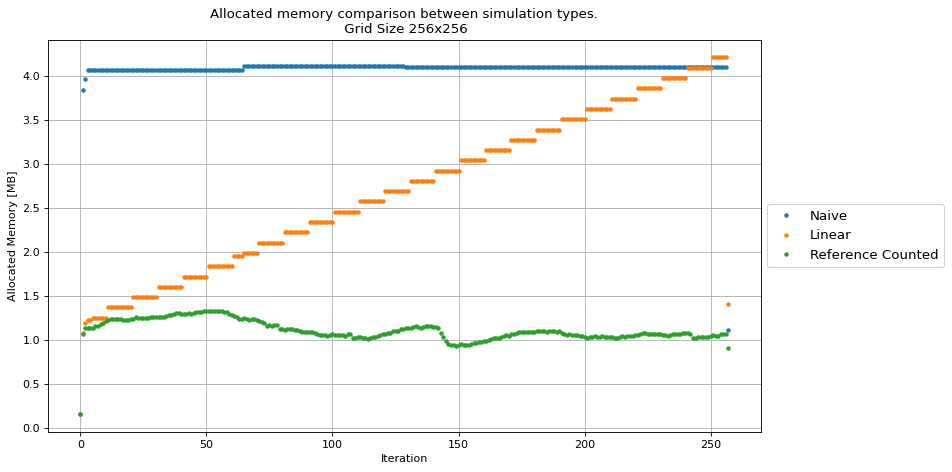

In [7]:
make_plot_mem(df, 256,256)

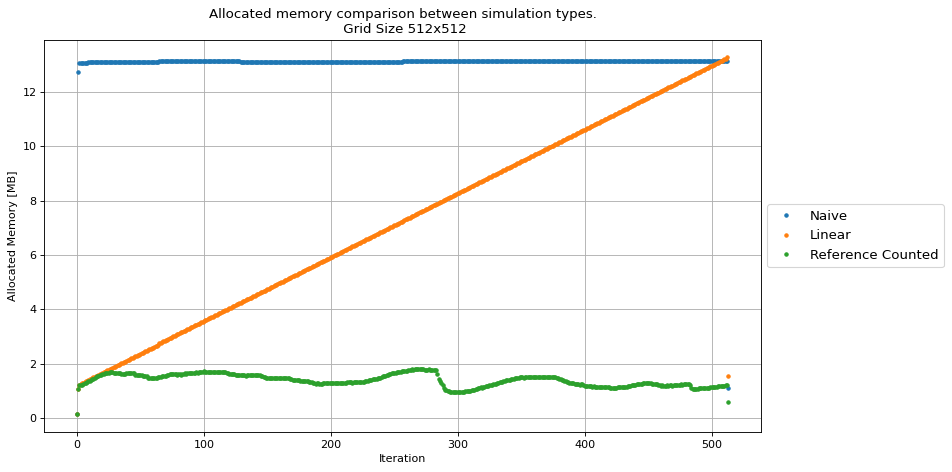

In [8]:
make_plot_mem(df, 512,512)

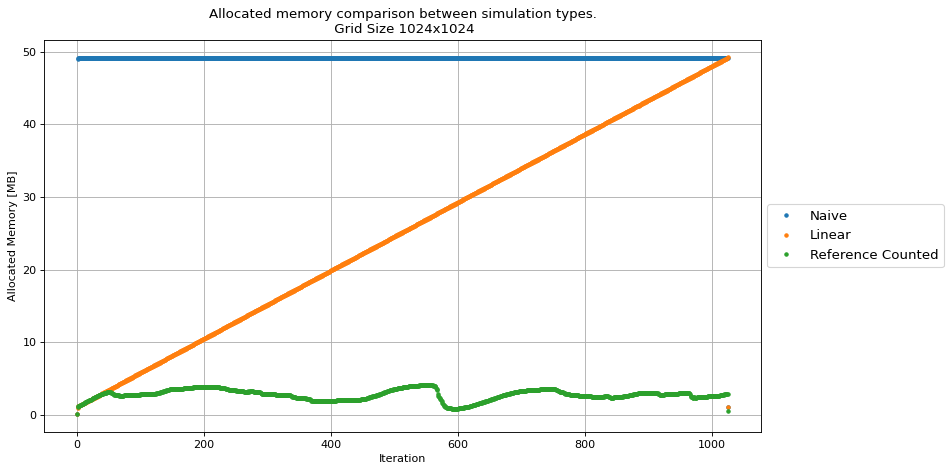

In [9]:
make_plot_mem(df, 1024,1024)

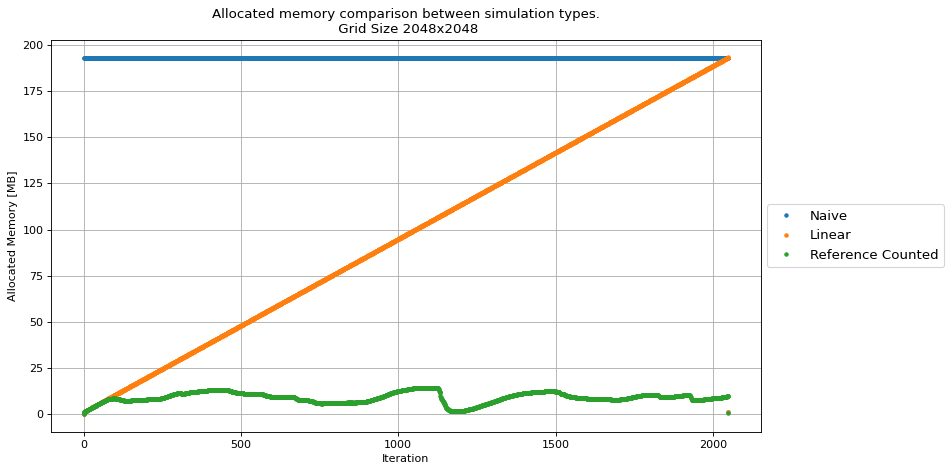

In [10]:
make_plot_mem(df, 2048,2048)

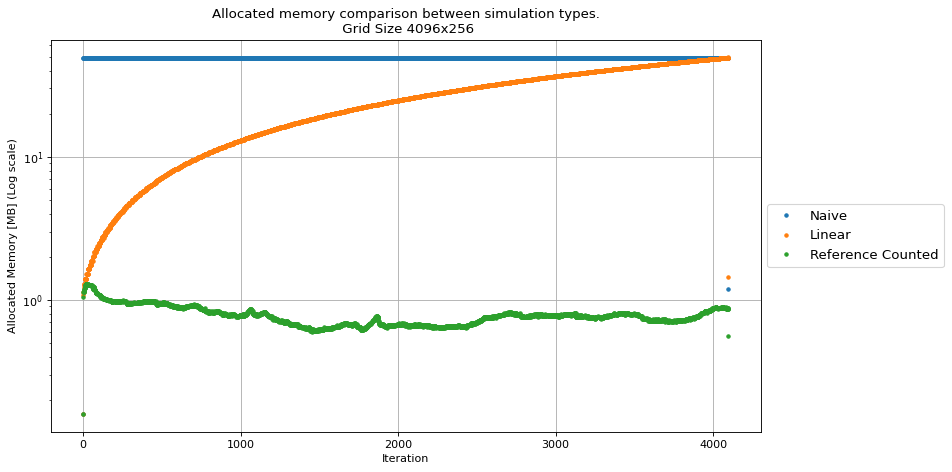

In [11]:
make_plot_mem(df, 4096,256, log = True)

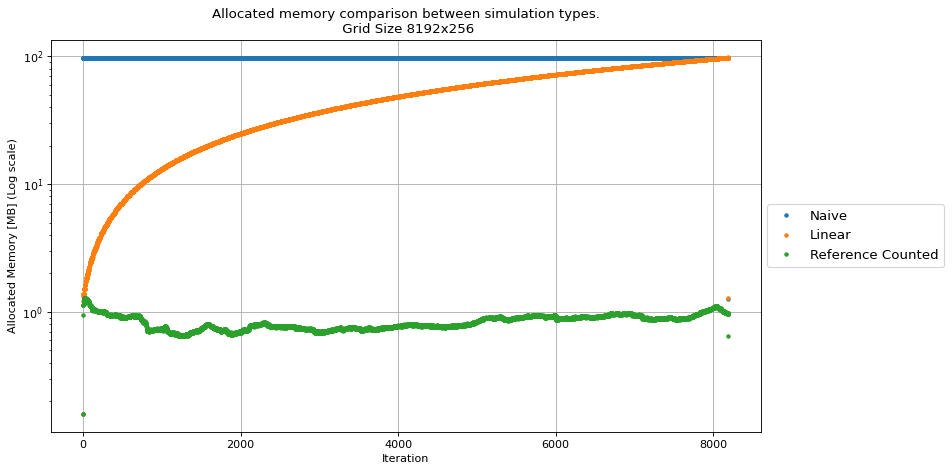

In [12]:
make_plot_mem(df, 8192,256, log = True)

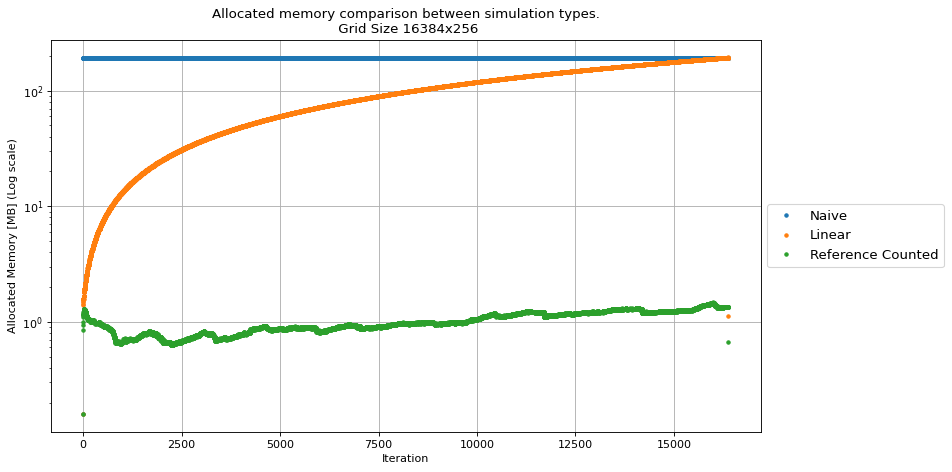

In [13]:
make_plot_mem(df, 16384,256, log = True)

In [14]:
wh_comp_idx = list(zip([64,   128,  256,  512,  1024, 2048, 4086, 8192], [8192, 4096, 2048, 1024, 512,  256,  128,  64]))


dfs = []
for x,y in wh_comp_idx:
    dfs.append( df[(df['x'] == x) & (df['y'] == y)])
df_wh = pd.concat(dfs)

rc_v_naive = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'naive']['corrected_alloc']
rc_v_linear = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'linear']['corrected_alloc']

In [15]:
def make_plot_denisty_res(df, xy_pairs, name2 = "", linear = False, log = False):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    if linear: 
        name = 'Linear'+name2
    else: 
        name ='Naive'+name2
    plt.title(f"Comparison of reduction in memory for Referene Counting vs {name} implmentation,\n based on shape of simulation ")
    plt.xlabel("Part of simulation completed [%]")
    plt.ylabel("Reduction of allocated memory (higher is better)")
    if log:
        plt.yscale('log')
        plt.ylabel("Allocated Memory [MB] (Log scale)")
    
    means = []
    maxes = []
    mins = []
    stds = []
    meds = []
    for x, y in xy_pairs:
        df_xy = df[(df['x'] == x) & (df['y'] == y)]
        df_naive =   df_xy[df_xy['sim_type'] == 'naive']
        df_rc =      df_xy[df_xy['sim_type'] == 'rc']
        df_linear =  df_xy[df_xy['sim_type'] == 'linear']
        if linear:
            df_t = df_linear
        else:
            df_t = df_naive
        df = df.sort_values(by=['id'])
        
        plt.plot(df_t['id'] * (8192 / x) /8196 * 100,  df_t['corrected_alloc'] / df_rc['corrected_alloc'], '--', label = f'simulation: {x}x{y}')
        means.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).mean())
        maxes.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).max())
        mins.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).min())
        stds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).std())
        meds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).median())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_sim_{name}.png')
    plt.show()

    
    def ratio(xy):
        for x,y in xy:
            yield x / y
    fig = plt.figure(figsize=(11, 6), dpi=80)
    plt.title(f"Reduction in memory as function of grid ratio `width / height`")
    plt.xlabel("Ratio of grid size")
    plt.ylabel("Allocated Memory reduction (higher is better)")
    plt.xscale('log')
    plt.plot(list(ratio(xy_pairs)), means, 'o--', label = 'Mean')
    plt.plot(list(ratio(xy_pairs)), maxes, 'o--', label = "Max")
    plt.plot(list(ratio(xy_pairs)), mins, 'o--', label = "Min")
    plt.plot(list(ratio(xy_pairs)), meds, 'o--', label = "Median")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_comp_{name}.png')
    plt.show()


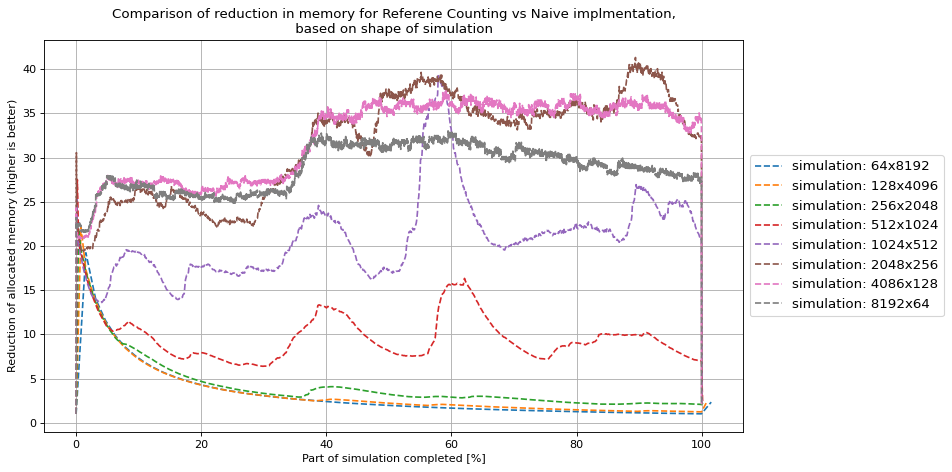

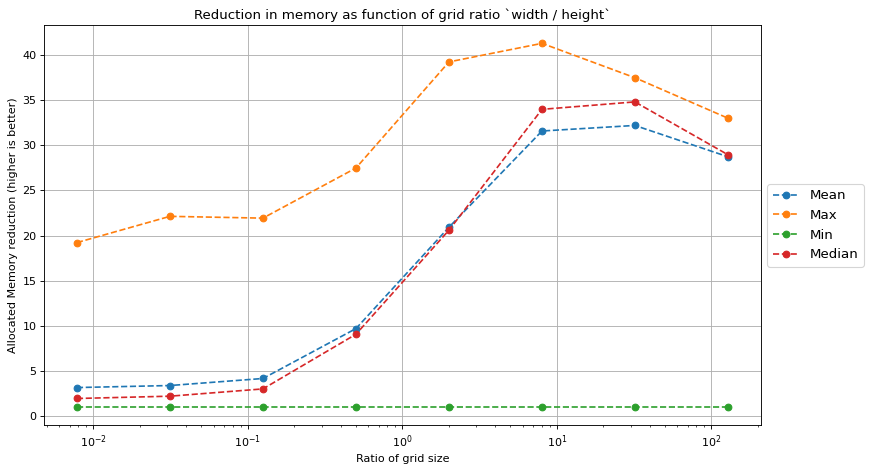

In [16]:
# for x,y in wh_comp_idx:
make_plot_denisty_res(df_wh,wh_comp_idx )

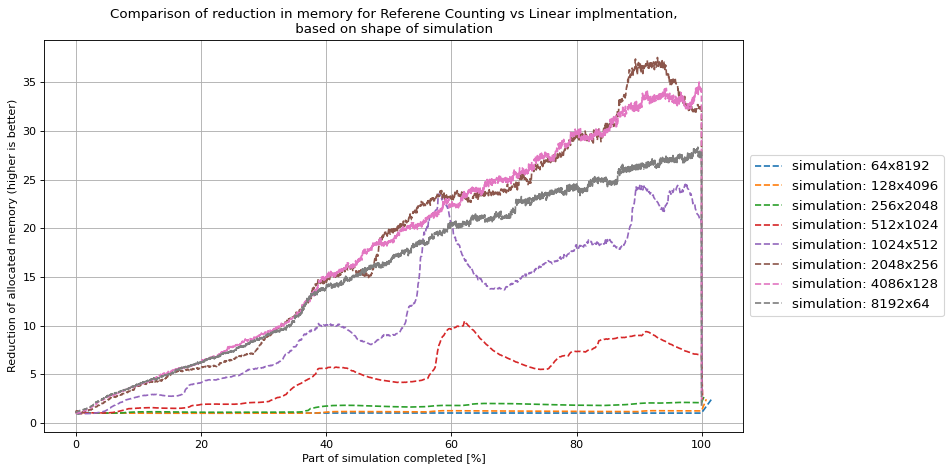

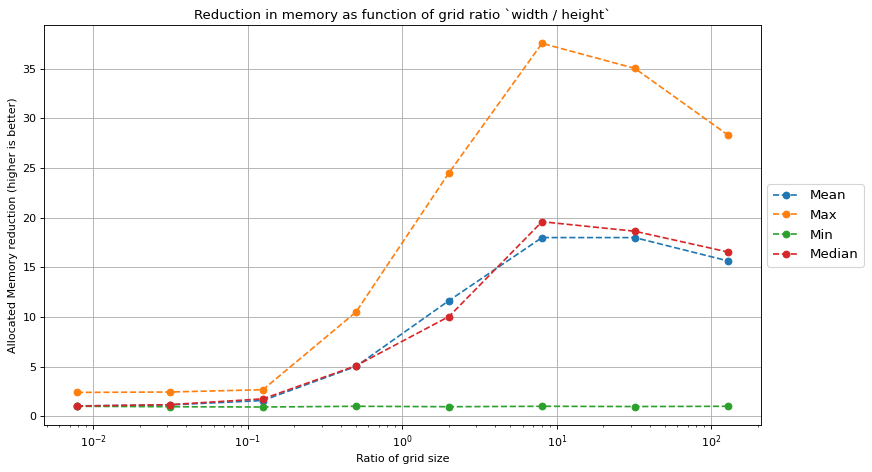

In [17]:
# for x,y in wh_comp_idx:
make_plot_denisty_res(df_wh, wh_comp_idx, linear= True)

In [18]:
wh_comp_idx = list(zip([256, 512,  1024, 2048], [256, 512,  1024, 2048]))


dfs = []
for x,y in wh_comp_idx:
    dfs.append( df[(df['x'] == x) & (df['y'] == y)])
df_wh = pd.concat(dfs)

rc_v_naive = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'naive']['corrected_alloc']
rc_v_linear = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'linear']['corrected_alloc']

In [19]:
def make_plot_denisty_res(df, xy_pairs, name2 = "", linear = False, log = False):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    if linear: 
        name = 'Linear'
    else: 
        name ='Naive'
    plt.title(f"Comparison of reduction in memory for Referene Counting vs {name} implmentation,\n based on the size oif simulation square ")
    plt.xlabel("Part of simulation completed [%]")
    plt.ylabel("Reduction of allocated memory (higher is better)")
    if log:
        plt.yscale('log')
        plt.ylabel("Allocated Memory [MB] (Log scale)")
    name =name+name2
    means = []
    maxes = []
    mins = []
    stds = []
    meds = []
    for x, y in xy_pairs:
        df_xy = df[(df['x'] == x) & (df['y'] == y)]
        df_naive =   df_xy[df_xy['sim_type'] == 'naive']
        df_rc =      df_xy[df_xy['sim_type'] == 'rc']
        df_linear =  df_xy[df_xy['sim_type'] == 'linear']
        if linear:
            df_t = df_linear
        else:
            df_t = df_naive
        df = df.sort_values(by=['id'])
        
        plt.plot(df_t['id'] * (2048 / x) /2048 * 100,  df_t['corrected_alloc'] / df_rc['corrected_alloc'], '--', label = f'simulation: {x}x{y}')
        means.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).mean())
        maxes.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).max())
        mins.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).min())
        stds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).std())
        meds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).median())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_sim_{name}.png')
    plt.show()

    
    def ratio(xy):
        for x,y in xy:
            yield x / y
    fig = plt.figure(figsize=(11, 6), dpi=80)
    plt.title(f"Reduction in memory as function of grid size")
    plt.xlabel("Grid size")
    plt.ylabel("Allocated Memory reduction (higher is better)")
    plt.xscale('log')
    print(xy_pairs)
    plt.plot(list(map(lambda x: x[0], xy_pairs)), means, 'o--', label = 'Mean')
    plt.plot(list(map(lambda x: x[0], xy_pairs)), maxes, 'o--', label = "Max")
    plt.plot(list(map(lambda x: x[0], xy_pairs)), mins, 'o--', label = "Min")
    plt.plot(list(map(lambda x: x[0], xy_pairs)), meds, 'o--', label = "Median")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_comp_{name}.png')
    plt.show()


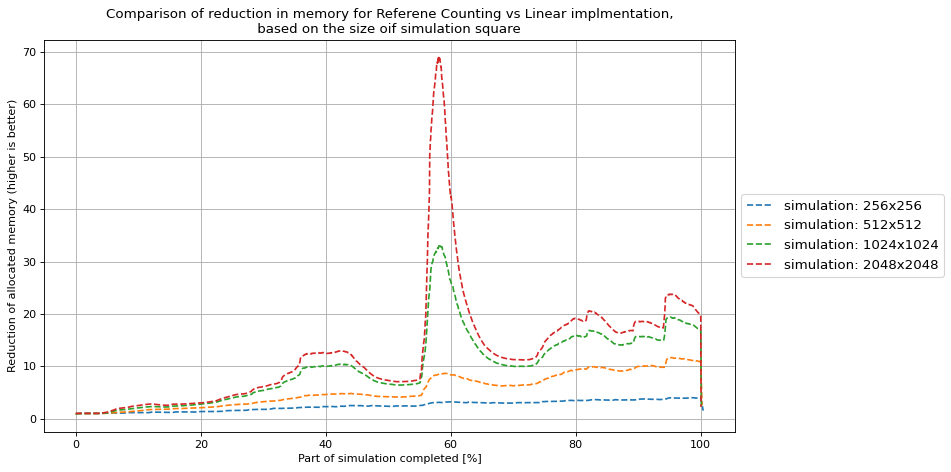

[(256, 256), (512, 512), (1024, 1024), (2048, 2048)]


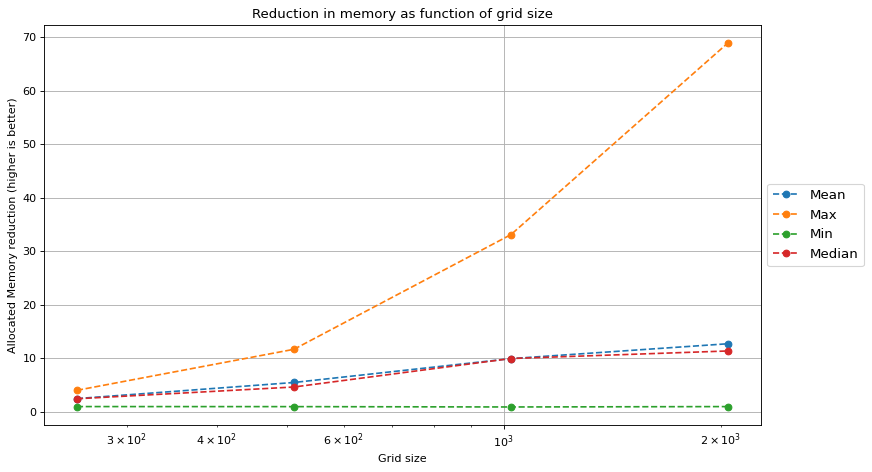

In [20]:
make_plot_denisty_res(df_wh,wh_comp_idx , linear=True, name2 ="square")

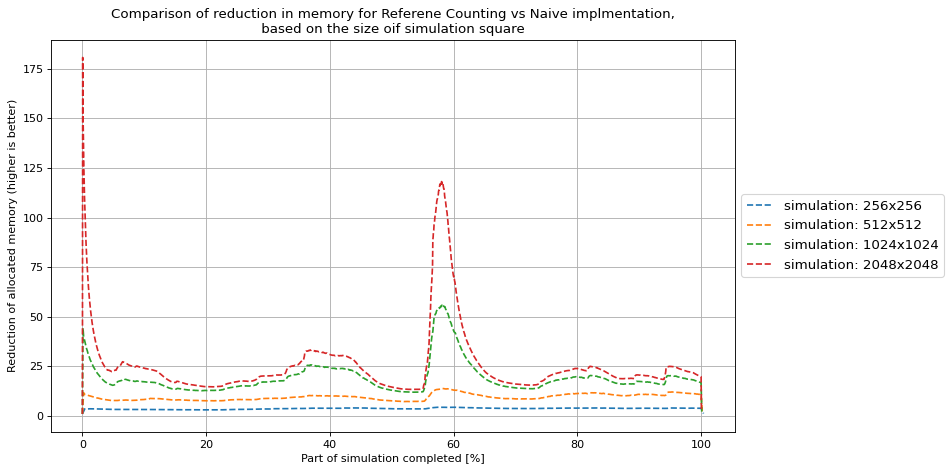

[(256, 256), (512, 512), (1024, 1024), (2048, 2048)]


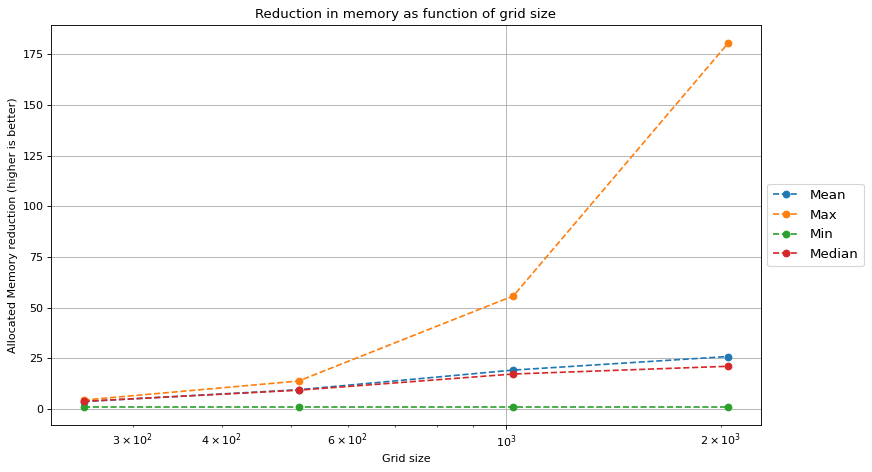

In [21]:
make_plot_denisty_res(df_wh,wh_comp_idx , name2='square')

In [22]:
wh_comp_idx = list(zip([2048, 4096,  8192, 16384], [256, 256,  256, 256]))


dfs = []
for x,y in wh_comp_idx:
    dfs.append( df[(df['x'] == x) & (df['y'] == y)])
df_wh = pd.concat(dfs)

rc_v_naive = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'naive']['corrected_alloc']
rc_v_linear = df_wh[df_wh['sim_type'] == 'rc']['corrected_alloc'] / df_wh[df_wh['sim_type'] == 'linear']['corrected_alloc']

In [23]:
def make_plot_denisty_res2(df, xy_pairs, name2 = "", linear = False, log = False):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    if linear: 
        name = 'Linear'
    else: 
        name ='Naive'
    plt.title(f"Comparison of reduction in memory for Referene Counting vs {name} implmentation,\n based on simulation length ")
    plt.xlabel("Part of simulation completed [%]")
    plt.ylabel("Reduction of allocated memory (higher is better)")
    if log:
        plt.yscale('log')
        plt.ylabel("Allocated Memory [MB] (Log scale)")
    name =name+name2
    means = []
    maxes = []
    mins = []
    stds = []
    meds = []
    for x, y in xy_pairs:
        df_xy = df[(df['x'] == x) & (df['y'] == y)]
        df_naive =   df_xy[df_xy['sim_type'] == 'naive']
        df_rc =      df_xy[df_xy['sim_type'] == 'rc']
        df_linear =  df_xy[df_xy['sim_type'] == 'linear']
        if linear:
            df_t = df_linear
        else:
            df_t = df_naive
        df = df.sort_values(by=['id'])
        
        plt.plot(df_t['id'] * (16384 / x) /16384 * 100,  df_t['corrected_alloc'] / df_rc['corrected_alloc'], '--', label = f'simulation: {x}x{y}')
        means.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).mean())
        maxes.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).max())
        mins.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).min())
        stds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).std())
        meds.append((df_t['corrected_alloc'] / df_rc['corrected_alloc']).median())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_sim_{name}.png')
    plt.show()

    
    def ratio(xy):
        for x,y in xy:
            yield x / y
    fig = plt.figure(figsize=(11, 6), dpi=80)
    plt.title(f"Reduction in memory as function of simulation length")
    plt.xlabel("Simulation length")
    plt.ylabel("Allocated Memory reduction (higher is better)")
    plt.xscale('log')
    print(xy_pairs)
    plt.plot(list(map(lambda x: x[0], xy_pairs)), means, 'o--', label = 'Mean')
    plt.plot(list(map(lambda x: x[0], xy_pairs)), maxes, 'o--', label = "Max")
    plt.plot(list(map(lambda x: x[0], xy_pairs)), mins, 'o--', label = "Min")
    plt.plot(list(map(lambda x: x[0], xy_pairs)), meds, 'o--', label = "Median")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'alloc_comp_{name}.png')
    plt.show()

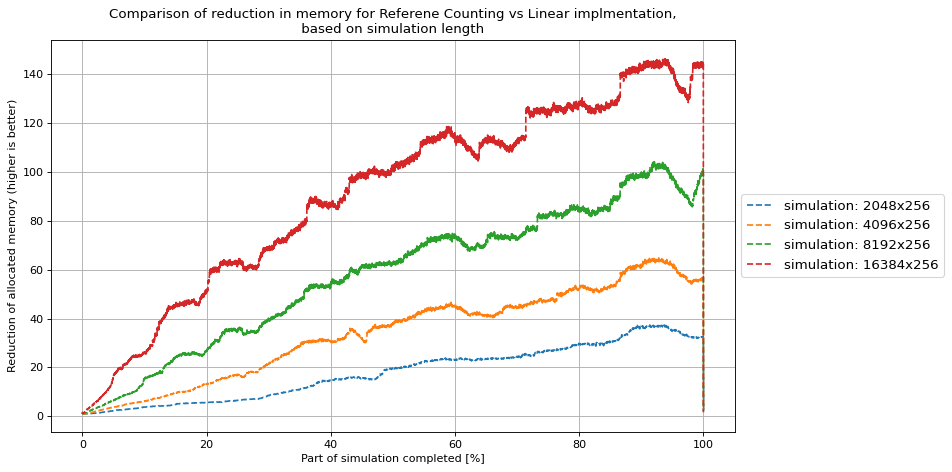

[(2048, 256), (4096, 256), (8192, 256), (16384, 256)]


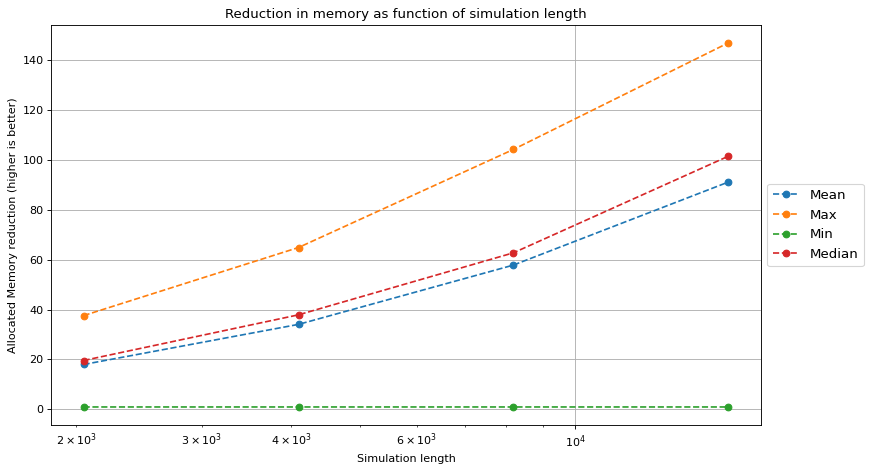

In [24]:
make_plot_denisty_res2(df_wh,wh_comp_idx, linear=True, name2 ="long")

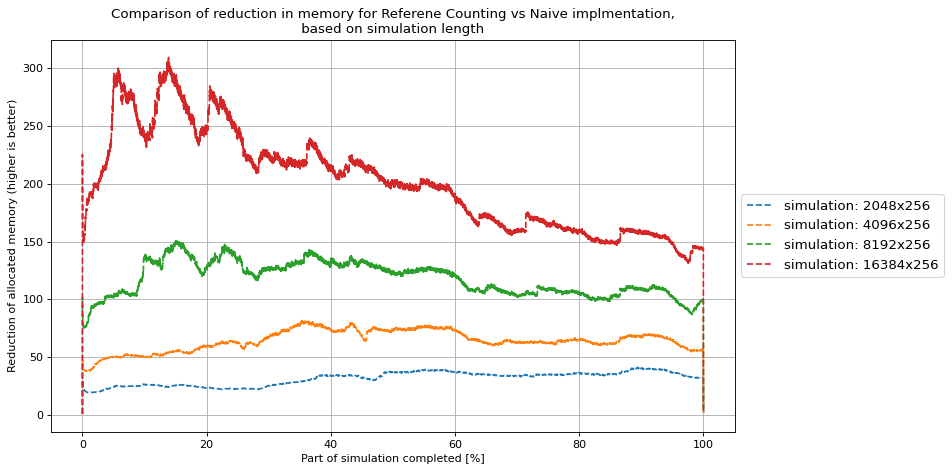

[(2048, 256), (4096, 256), (8192, 256), (16384, 256)]


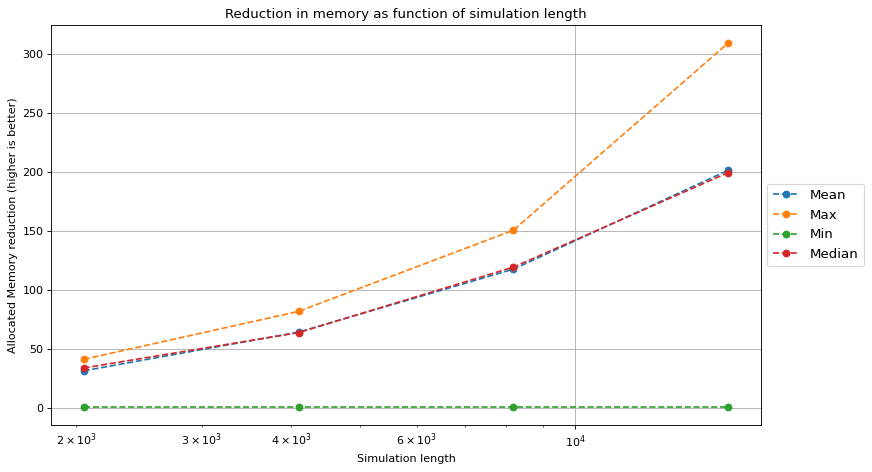

In [25]:
make_plot_denisty_res2(df_wh,wh_comp_idx, name2 ="long")